# TP2 - CLASE 3

## 1. Medición de foco en toda la imagen

### Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: **focus_video.mov**.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper **"Image Sharpness Measure for Blurred Images in Frequency Domain"** y realizar tres experimentos:

1. **Medición sobre todo el frame.**
2. **Medición sobre una ROI ubicada en el centro del frame.** Área de la ROI = 5 o 10% del área total del frame.

### Opcional:
1. **Medición sobre una matriz de enfoque** compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc. (al menos 3)

### Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detectó el punto de máximo enfoque.

In [1]:
#Libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# open video file and extract metadata
video_path = "data/focus_video.mov"

if os.path.exists(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    
    video_info = {
        'frames': frame_count,
        'resolution': f"{width}x{height}",
        'width': width,
        'height': height,
        'fps': fps,
        'duration_seconds': duration,
        'codec': int(cap.get(cv2.CAP_PROP_FOURCC))
    }
    
    cap.release()
    
    for key, value in video_info.items():
        if key == 'codec':
            codec_str = ''.join([chr((value >> 8 * i) & 0xFF) for i in range(4)])
            print(f"{key}: {codec_str}")
        elif key == 'duration_seconds':
            print(f"{key}: {value:.2f}")
        elif key == 'fps':
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
            
else:
    print(f"Video file not found: {video_path}")

frames: 171
resolution: 640x360
width: 640
height: 360
fps: 29.97
duration_seconds: 5.71
codec: h264


In [3]:
# create a video showing the Fourier transform of each frame
os.makedirs("outputs", exist_ok=True)

input_path = "data/focus_video.mov"
output_path = "outputs/fourier_transform_video.mp4"

cap = cv2.VideoCapture(input_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    
    magnitude_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    magnitude_bgr = cv2.cvtColor(magnitude_normalized, cv2.COLOR_GRAY2BGR)
    
    out.write(magnitude_bgr)

cap.release()
out.release()

print(f"Fourier transform video saved to: {output_path}")

Fourier transform video saved to: outputs/fourier_transform_video.mp4


3. Proposed Algorithm for calculating Image Quality measure
3.1 Algorithm for image quality measure
Input: Image I of size M×N.
Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure
Step 1: Compute F which is the Fourier Transform representation of image I
Step 2: Find Fc which is obtained by shifting the origin of F to centre.
Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
Step 6: Calculate Image Quality measure (FM) from equation (1).
FM = TH / (M * N) (1)

In [4]:
def calculate_image_quality(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    M = np.max(magnitude_spectrum)
    thres = M / 1000
    TH = np.sum(magnitude_spectrum > thres)
    N = image.shape[0] * image.shape[1]
    
    FM = TH / (M * N) if M * N != 0 else 0
    return FM

In [5]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    quality = calculate_image_quality(frame)
    quality_scores.append(quality)
cap.release()


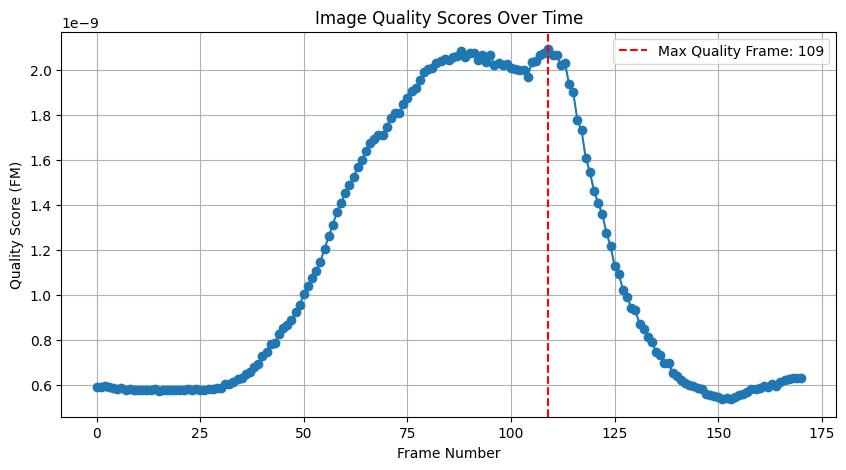

Max quality score: 0.000000 at frame 109


In [6]:
# Plot quality scores over time
max = np.argmax(quality_scores) if quality_scores else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores, marker='o')
plt.axvline(x=max, color='r', linestyle='--', label=f'Max Quality Frame: {max}')
plt.title('Image Quality Scores Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score: {quality_scores[max]:.6f} at frame {max}")

In [7]:
def calculate_image_quality_roi(image, porcentage_roi=0.05):
    im=image.copy()
    h, w, _ = im.shape
    roi_h, roi_w = int(h * porcentage_roi), int(w * porcentage_roi)
    start_h, start_w = (h - roi_h) // 2, (w - roi_w) // 2
    roi = im[start_h:start_h + roi_h, start_w:start_w + roi_w]
    FM=calculate_image_quality(roi)
    
    return FM

In [8]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    quality_5p = calculate_image_quality_roi(frame, porcentage_roi=0.05)
    quality_scores_5p.append(quality_5p)
    quality_10p = calculate_image_quality_roi(frame, porcentage_roi=0.10)
    quality_scores_10p.append(quality_10p)
cap.release()

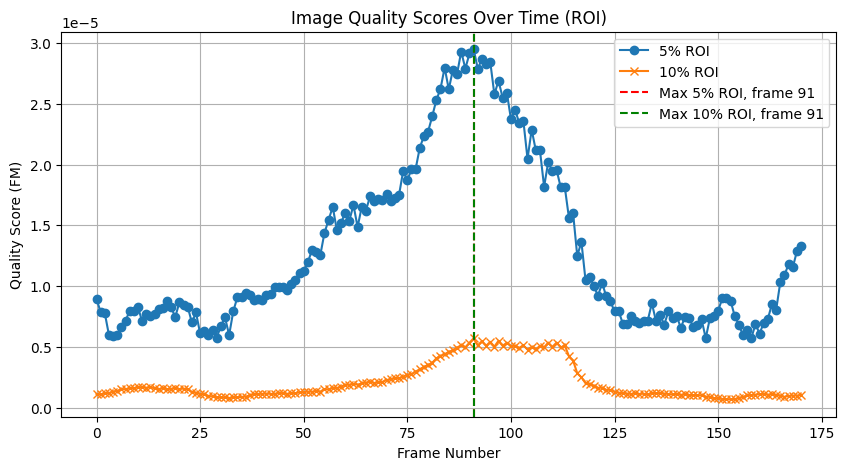

Max quality score (5% ROI): 0.000029 at frame 91
Max quality score (10% ROI): 0.000006 at frame 91


In [9]:
# Plot quality scores ROI over time and the max value
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores_5p, marker='o', label='5% ROI')
plt.plot(quality_scores_10p, marker='x', label='10% ROI')
plt.axvline(x=max_5p, color='r', linestyle='--', label=f'Max 5% ROI, frame {max_5p}' if quality_scores_5p else '')
plt.axvline(x=max_10p, color='g', linestyle='--', label=f'Max 10% ROI, frame {max_10p}' if quality_scores_10p else '')
plt.title('Image Quality Scores Over Time (ROI)')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score (5% ROI): {quality_scores_5p[max_5p]:.6f} at frame {max_5p}")
print(f"Max quality score (10% ROI): {quality_scores_10p[max_10p]:.6f} at frame {max_10p}")

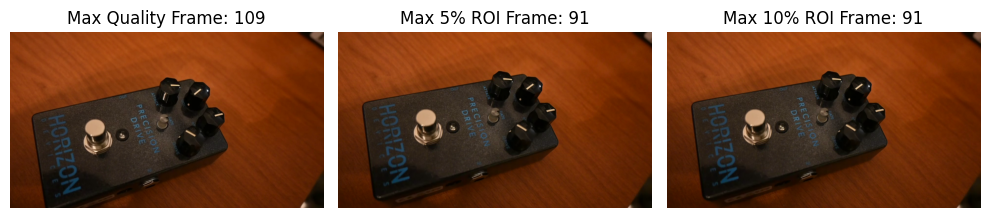

In [10]:
# Plot the max quality frame for all the algorithms
max = np.argmax(quality_scores) if quality_scores else 0
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max:
        max_frame = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_5p:
        max_frame_5p = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_10p:
        max_frame_10p = frame.copy()
cap.release()
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
plt.title(f'Max Quality Frame: {max}')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(max_frame_5p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 5% ROI Frame: {max_5p}')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(max_frame_10p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 10% ROI Frame: {max_10p}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_image_quality_matrix(image, matrix_size=(3, 3), roi_percentage=0.6):
    """
    Calcula la matriz de calidad de imagen con elementos rectangulares equiespaciados
    dentro de una ROI centrada.
    
    Parameters:
    - image: imagen de entrada
    - matrix_size: tupla (filas, columnas) que define la matriz NxM
    - roi_percentage: porcentaje del tamaño de la imagen para la ROI
    """
    rows, cols = matrix_size
    h, w = image.shape[:2]
    
    # Definir la ROI centrada
    roi_h = int(h * roi_percentage)
    roi_w = int(w * roi_percentage)
    roi_start_h = (h - roi_h) // 2
    roi_start_w = (w - roi_w) // 2
    roi_end_h = roi_start_h + roi_h
    roi_end_w = roi_start_w + roi_w
    
    # Para crear el patrón "una celda sí, una celda no" dentro de la ROI
    total_rows = rows * 2  # filas totales incluyendo espacios
    total_cols = cols * 2  # columnas totales incluyendo espacios
    
    cell_h = roi_h // total_rows
    cell_w = roi_w // total_cols
    
    quality_matrix = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            # Calcular posición saltando una celda (patrón equiespaciado)
            actual_row = i * 2  # Saltar una fila entre celdas
            actual_col = j * 2  # Saltar una columna entre celdas
            
            # Posiciones relativas dentro de la ROI
            start_h_roi = actual_row * cell_h
            end_h_roi = start_h_roi + cell_h
            start_w_roi = actual_col * cell_w
            end_w_roi = start_w_roi + cell_w
            
            # Convertir a coordenadas absolutas de la imagen
            start_h = roi_start_h + start_h_roi
            end_h = roi_start_h + end_h_roi
            start_w = roi_start_w + start_w_roi
            end_w = roi_start_w + end_w_roi
            
            # Asegurar que no excedamos los límites de la ROI
            end_h = min(end_h, roi_end_h)
            end_w = min(end_w, roi_end_w)
            
            # Extraer la celda y calcular su calidad
            if start_h < roi_end_h and start_w < roi_end_w:
                cell = image[start_h:end_h, start_w:end_w]
                if cell.size > 0:  # Verificar que la celda no esté vacía
                    quality_matrix[i, j] = calculate_image_quality(cell)
    
    return quality_matrix

In [21]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)

matrix_sizes = [(3, 3), (5, 7), (7, 5)]
roi_percentage = 0.6  # ROI del 60% del tamaño de la imagen
quality_scores_matrix = {str(size): [] for size in matrix_sizes}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    for matrix_size in matrix_sizes:
        quality_matrix = calculate_image_quality_matrix(frame, matrix_size, roi_percentage)
        avg_quality = np.mean(quality_matrix)
        quality_scores_matrix[str(matrix_size)].append(avg_quality)

cap.release()

print(f"Análisis completado con ROI del {int(roi_percentage*100)}% del tamaño de la imagen")
print(f"Matriz de enfoque aplicada dentro de la ROI centrada")

Análisis completado con ROI del 60% del tamaño de la imagen
Matriz de enfoque aplicada dentro de la ROI centrada


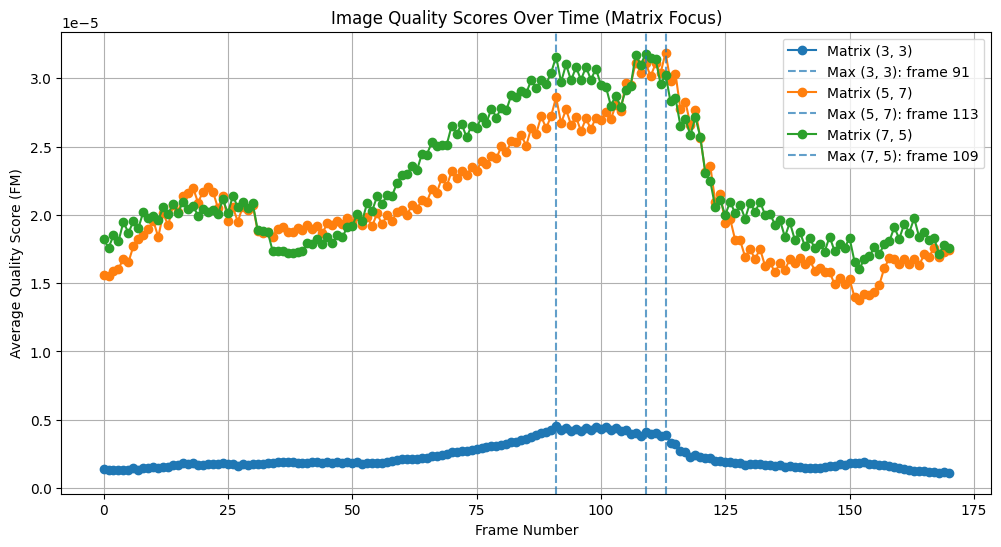

Matrix (3, 3) - Max quality: 0.000005 at frame 91
Matrix (5, 7) - Max quality: 0.000032 at frame 113
Matrix (7, 5) - Max quality: 0.000032 at frame 109


In [22]:
plt.figure(figsize=(12, 6))
for i, (matrix_size, scores) in enumerate(quality_scores_matrix.items()):
    max_idx = np.argmax(scores) if scores else 0
    plt.plot(scores, marker='o', label=f'Matrix {matrix_size}')
    plt.axvline(x=max_idx, linestyle='--', alpha=0.7, label=f'Max {matrix_size}: frame {max_idx}')

plt.title('Image Quality Scores Over Time (Matrix Focus)')
plt.xlabel('Frame Number')
plt.ylabel('Average Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()

for matrix_size, scores in quality_scores_matrix.items():
    if scores:
        max_idx = np.argmax(scores)
        print(f"Matrix {matrix_size} - Max quality: {scores[max_idx]:.6f} at frame {max_idx}")

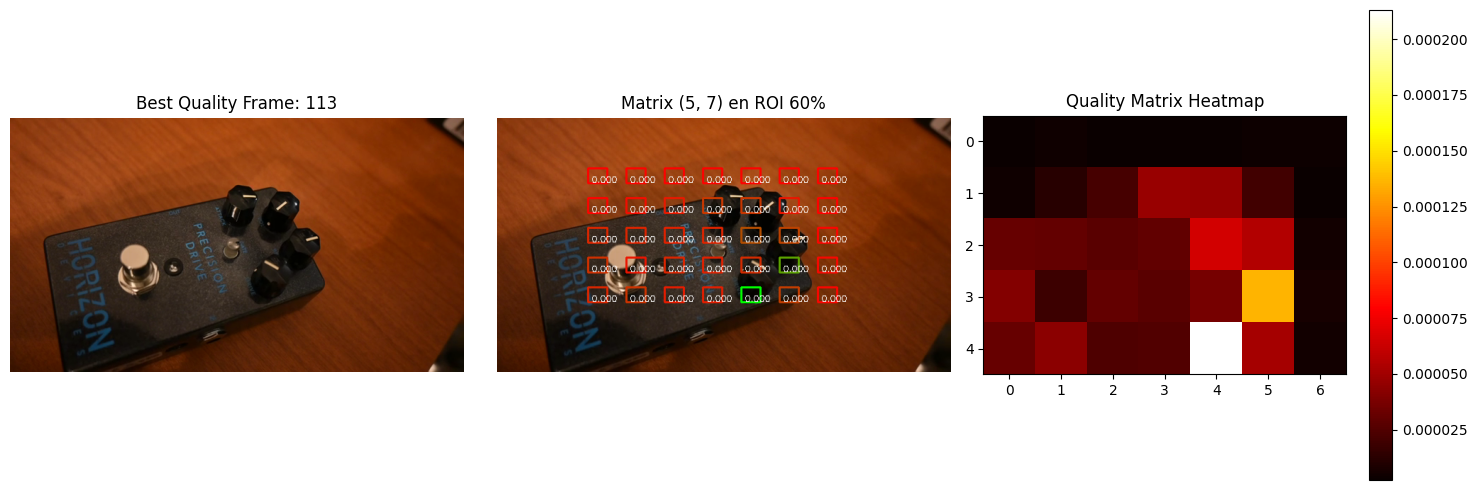

In [ ]:
def visualize_matrix_overlay(image, matrix_size, quality_matrix, roi_coords, roi_percentage=0.6):
    """
    Visualiza la matriz de calidad superpuesta en la imagen con patrón equiespaciado
    dentro de una ROI (una celda sí, una celda no)
    """
    h, w = image.shape[:2]
    rows, cols = matrix_size
    roi_start_h, roi_start_w, roi_end_h, roi_end_w = roi_coords
    roi_h = roi_end_h - roi_start_h
    roi_w = roi_end_w - roi_start_w
    
    # Para el patrón "una celda sí, una celda no" dentro de la ROI
    total_rows = rows * 2
    total_cols = cols * 2
    
    cell_h = roi_h // total_rows
    cell_w = roi_w // total_cols
    
    overlay = image.copy()
    
    
    for i in range(rows):
        for j in range(cols):
            # Calcular posición con el patrón equiespaciado dentro de la ROI
            actual_row = i * 2
            actual_col = j * 2
            
            # Posiciones relativas dentro de la ROI
            start_h_roi = actual_row * cell_h
            end_h_roi = start_h_roi + cell_h
            start_w_roi = actual_col * cell_w
            end_w_roi = start_w_roi + cell_w
            
            # Convertir a coordenadas absolutas
            start_h = roi_start_h + start_h_roi
            end_h = roi_start_h + end_h_roi
            start_w = roi_start_w + start_w_roi
            end_w = roi_start_w + end_w_roi
            
            # Asegurar que no excedamos los límites de la ROI
            end_h = min(end_h, roi_end_h)
            end_w = min(end_w, roi_end_w)
            
            quality_val = quality_matrix[i, j]
            max_quality = np.max(quality_matrix)
            
            # Color basado en la calidad relativa
            intensity = int(255 * (quality_val / max_quality)) if max_quality > 0 else 0
            color = (0, intensity, 255 - intensity)  # De azul (baja calidad) a verde (alta calidad)
            
            # Dibujar rectángulo y texto
            cv2.rectangle(overlay, (start_w, start_h), (end_w, end_h), color, 2)
            cv2.putText(overlay, f'{quality_val:.3f}', (start_w + 5, start_h + 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    return overlay

best_score = 0
best_matrix_size = None
for matrix_key, scores in quality_scores_matrix.items():
    if scores and np.max(scores) > best_score:
        best_score = np.max(scores)
        best_matrix_size = matrix_key

best_frame_idx = np.argmax(quality_scores_matrix[best_matrix_size]) if best_matrix_size else 0

cap = cv2.VideoCapture(input_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
ret, best_frame = cap.read()
cap.release()

if ret:
    matrix_size = eval(best_matrix_size)
    quality_matrix = calculate_image_quality_matrix(best_frame, matrix_size, roi_percentage=0.6)
    overlay_image = visualize_matrix_overlay(best_frame, matrix_size, quality_matrix, roi_percentage=0.6)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Quality Frame: {best_frame_idx}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Matrix {matrix_size} en ROI 60%')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(quality_matrix, cmap='hot', interpolation='nearest')
    plt.title('Quality Matrix Heatmap')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

## 2. Cambiar la métrica de enfoque
Eligiendo uno de los algoritmos explicados en el apéndice de: **"Analysis of focus measure operators in shape from focus"**.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

### Resultados esperados:
- Matriz de enfoque superpuesta a uno de los frames del video
- Gráfico de la métrica asociado al experimento

### Puntos extra:
Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

Analizando las conclusiones del paper **"Analysis of focus measure operators in shape from focus"** vemos que el mejor operador para medir el enfoque cuando hay ruido gauseano es el gray-level variance (STA3, en el paper) que sufre poco al aumentar el ruido.
En cambio el mejor operador en generel es el Laplacian modificado (LAP2 en el paper). Este operador es sensible al ruido por que realiza una segunda derivada, pero es el que mejor resultados da en condiciones ideales.
Por lo explicado anteriormente se van a implementar ambos y comparar resultados para nuestro video.

## 1. Operador (Varianza - STA3)

STA3(i, j) = (1 / N) * SUM((x, y) en W_i,j) [ (I(x, y) - mu_i,j) ^ 2 ]
mu_i,j = (1 / N) * SUM((x, y) en W_i,j) [ I(x, y) ]


## 2. Operador (Laplaciano Modificado - LAP2)
LAP2(x, y) = SUM((i, j) en W_x,y) [ DmI(i, j) ]
DmI(i, j) = | I * LX | + | I * LY |


In [24]:
def calculate_sta3_focus_measure(image, window_size=3):
    """
    Implementa el operador STA3 (Gray-level Variance) para medir el enfoque
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    gray = gray.astype(np.float32)
    h, w = gray.shape
    t = window_size
    half_t = t // 2
    
    focus_map = np.zeros((h, w), dtype=np.float32)
    
    for i in range(half_t, h - half_t):
        for j in range(half_t, w - half_t):
            
            suma_pixeles = 0
            n = t * t
            
            # Calcular la media de la ventana
            for x in range(i - half_t, i + half_t + 1):
                for y in range(j - half_t, j + half_t + 1):
                    suma_pixeles += gray[x, y]
            
            media_ventana = suma_pixeles / n
            
            # Calcular la varianza de la ventana
            suma_diferencias_cuadradas = 0
            for x in range(i - half_t, i + half_t + 1):
                for y in range(j - half_t, j + half_t + 1):
                    diferencia = gray[x, y] - media_ventana
                    suma_diferencias_cuadradas += diferencia * diferencia
            
            varianza_sta3 = suma_diferencias_cuadradas / n
            focus_map[i, j] = varianza_sta3
    
    return focus_map

def calculate_lap2_focus_measure(image, window_size=3):
    """
    Implementa el operador LAP2 (Laplaciano Modificado) para medir el enfoque
    Siguiendo el algoritmo paso a paso descrito
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    gray = gray.astype(np.float32)
    h, w = gray.shape
    T = window_size
    half_T = T // 2
    
    # Paso 1: Definir las máscaras
    LX = np.array([-1, 2, -1], dtype=np.float32)  # Máscara horizontal
    LY = np.array([[-1], [2], [-1]], dtype=np.float32)  # Máscara vertical
    
    # Paso 2: Calcular el Laplaciano Modificado DmI para toda la imagen
    IMAGEN_DmI = np.zeros((h, w), dtype=np.float32)
    
    for i in range(1, h - 1):  # Evitar bordes para la convolución
        for j in range(1, w - 1):
            # a. Calcular la segunda derivada horizontal (convolución con LX)
            derivada_x = 0
            for k in range(3):
                derivada_x += gray[i, j - 1 + k] * LX[k]
            derivada_x = abs(derivada_x)
            
            # b. Calcular la segunda derivada vertical (convolución con LY)
            derivada_y = 0
            for k in range(3):
                derivada_y += gray[i - 1 + k, j] * LY[k, 0]
            derivada_y = abs(derivada_y)
            
            # c. Combinar los resultados (DmI)
            IMAGEN_DmI[i, j] = derivada_x + derivada_y
    
    # Paso 3: Acumular la medida DmI en una ventana para obtener LAP2
    IMAGEN_SALIDA = np.zeros((h, w), dtype=np.float32)
    
    for x in range(half_T, h - half_T):
        for y in range(half_T, w - half_T):
            # Sumar todos los valores de DmI en la ventana W_x,y
            suma_dm = 0
            for i in range(x - half_T, x + half_T + 1):
                for j in range(y - half_T, y + half_T + 1):
                    suma_dm += IMAGEN_DmI[i, j]
            
            # El valor de enfoque LAP2 es la suma acumulada de DmI
            IMAGEN_SALIDA[x, y] = suma_dm
    
    return IMAGEN_SALIDA

def max_focus_points(focus_map):
    """funcion que obtiene los pixeles de maximo foco"""
    max_value = np.max(focus_map)
    
    max_positions = np.where(focus_map == max_value)
    
    max_points = list(zip(max_positions[0], max_positions[1]))
    
    return max_points, max_value

def create_focus_points_video(input_path, output_path, algorithm='sta3', window_size=3):
    """
    Genera un video que muestra los puntos de máximo enfoque superpuestos al video original
    
    Parameters:
    - input_path: ruta del video de entrada
    - output_path: ruta del video de salida
    - algorithm: 'sta3' para Gray-level Variance o 'lap2' para Laplaciano Modificado
    - window_size: tamaño de la ventana para el algoritmo
    """
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Seleccionar el algoritmo
    if algorithm.lower() == 'sta3':
        focus_function = calculate_sta3_focus_measure
        algorithm_name = "STA3 (Gray-level Variance)"
    elif algorithm.lower() == 'lap2':
        focus_function = calculate_lap2_focus_measure
        algorithm_name = "LAP2 (Laplaciano Modificado)"
    else:
        raise ValueError("Algorithm must be 'sta3' or 'lap2'")
    
    print(f"Procesando {frame_count} frames con algoritmo {algorithm_name}...")
    
    for frame_idx in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        focus_map = focus_function(frame, window_size)
        max_points, max_value = max_focus_points(focus_map)
        
        output_frame = frame.copy()
        
        # Dibujar los puntos de máximo enfoque
        for point in max_points:
            row, col = point
            cv2.circle(output_frame, (col, row), 5, (0, 0, 255), -1)
            cv2.circle(output_frame, (col, row), 15, (0, 0, 255), 2)
        
        # Texto informativo
        text = f'Frame: {frame_idx} | {algorithm_name} | Max Focus: {max_value:.2f} | Points: {len(max_points)}'
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

        out.write(output_frame)
        
        if frame_idx % 10 == 0:  # Mostrar progreso cada 10 frames
            print(f"Procesado frame {frame_idx}/{frame_count}")
    
    cap.release()
    out.release()
    
    print(f"Video con puntos de enfoque guardado en: {output_path}")
    print(f"Algoritmo utilizado: {algorithm_name}")
    return output_path

In [25]:
# Generar videos con ambos algoritmos para comparar
input_video = "data/focus_video.mov"

# Video con algoritmo STA3 (Gray-level Variance)
output_video_sta3 = "outputs/focus_points_video_STA3.mp4"
create_focus_points_video(input_video, output_video_sta3, algorithm='sta3', window_size=3)

# Video con algoritmo LAP2 (Laplaciano Modificado)
output_video_lap2 = "outputs/focus_points_video_LAP2.mp4"
create_focus_points_video(input_video, output_video_lap2, algorithm='lap2', window_size=3)

Procesando 171 frames con algoritmo STA3 (Gray-level Variance)...
Procesado frame 0/171
Procesado frame 0/171
Procesado frame 10/171
Procesado frame 10/171
Procesado frame 20/171
Procesado frame 20/171
Procesado frame 30/171
Procesado frame 30/171
Procesado frame 40/171
Procesado frame 40/171
Procesado frame 50/171
Procesado frame 50/171
Procesado frame 60/171
Procesado frame 60/171
Procesado frame 70/171
Procesado frame 70/171
Procesado frame 80/171
Procesado frame 80/171
Procesado frame 90/171
Procesado frame 90/171
Procesado frame 100/171
Procesado frame 100/171
Procesado frame 110/171
Procesado frame 110/171
Procesado frame 120/171
Procesado frame 120/171
Procesado frame 130/171
Procesado frame 130/171
Procesado frame 140/171
Procesado frame 140/171
Procesado frame 150/171
Procesado frame 150/171
Procesado frame 160/171
Procesado frame 160/171
Procesado frame 170/171
Video con puntos de enfoque guardado en: outputs/focus_points_video_STA3.mp4
Algoritmo utilizado: STA3 (Gray-level V

'outputs/focus_points_video_LAP2.mp4'

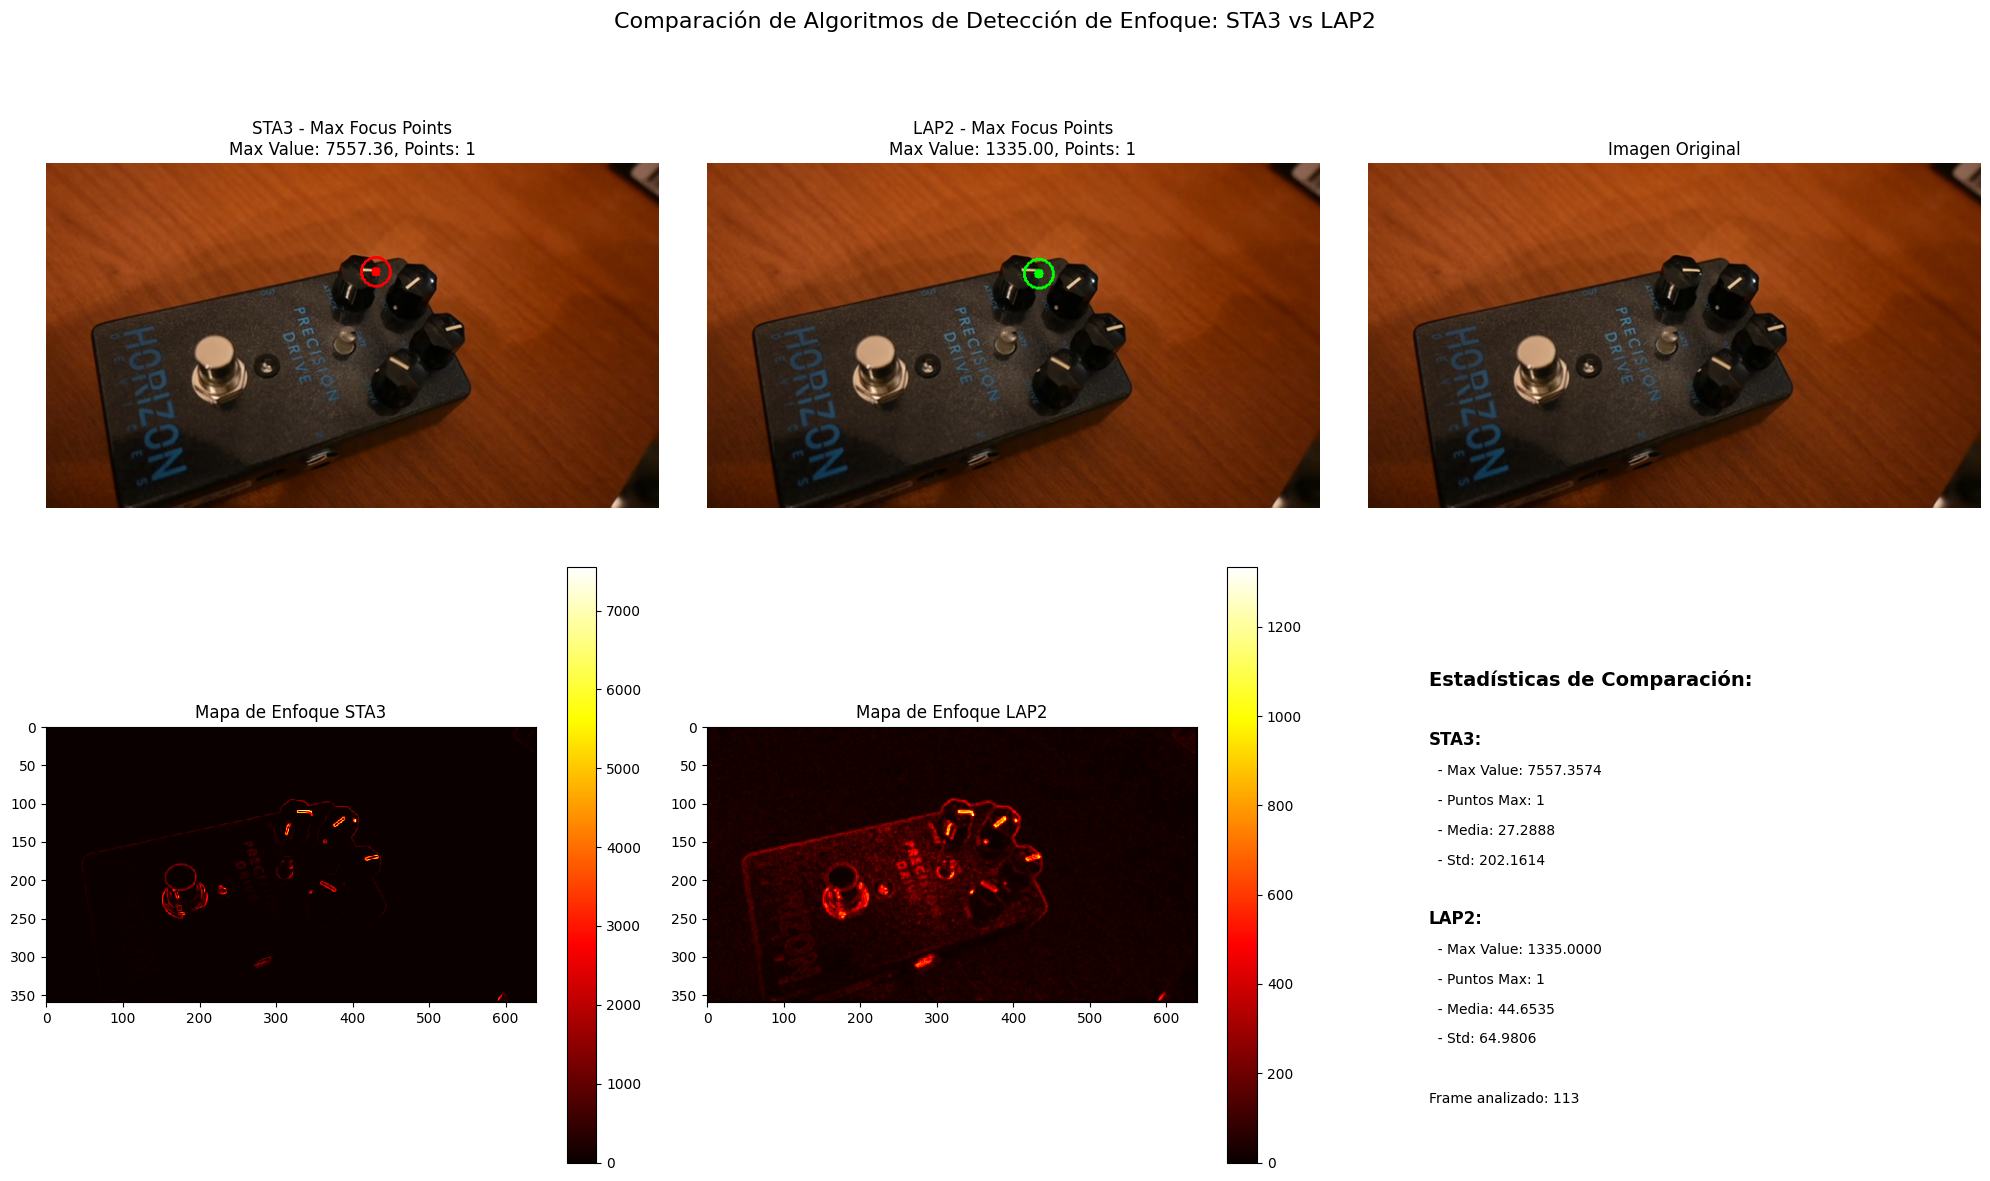

Comparación de algoritmos completada:
- STA3 (Gray-level Variance): 1 puntos de máximo enfoque
- LAP2 (Laplaciano Modificado): 1 puntos de máximo enfoque
- Frame analizado: 113


In [28]:
# Comparación visual de ambos algoritmos en un frame específico
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)

# Usar el frame con mejor calidad que encontramos anteriormente
cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
ret, test_frame = cap.read()
cap.release()

if ret:
    # Calcular mapas de enfoque con ambos algoritmos
    focus_map_sta3 = calculate_sta3_focus_measure(test_frame, window_size=3)
    focus_map_lap2 = calculate_lap2_focus_measure(test_frame, window_size=3)
    
    # Encontrar puntos de máximo enfoque
    max_points_sta3, max_value_sta3 = max_focus_points(focus_map_sta3)
    max_points_lap2, max_value_lap2 = max_focus_points(focus_map_lap2)
    
    # Crear imágenes con puntos superpuestos
    frame_sta3 = test_frame.copy()
    frame_lap2 = test_frame.copy()
    
    # Dibujar puntos STA3
    for point in max_points_sta3:
        row, col = point
        cv2.circle(frame_sta3, (col, row), 5, (0, 0, 255), -1)
        cv2.circle(frame_sta3, (col, row), 15, (0, 0, 255), 2)
    
    # Dibujar puntos LAP2
    for point in max_points_lap2:
        row, col = point
        cv2.circle(frame_lap2, (col, row), 5, (0, 255, 0), -1)
        cv2.circle(frame_lap2, (col, row), 15, (0, 255, 0), 2)
    
    # Visualización comparativa
    plt.figure(figsize=(20, 12))
    
    # Fila superior: Imágenes originales con puntos
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(frame_sta3, cv2.COLOR_BGR2RGB))
    plt.title(f'STA3 - Max Focus Points\nMax Value: {max_value_sta3:.2f}, Points: {len(max_points_sta3)}')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(frame_lap2, cv2.COLOR_BGR2RGB))
    plt.title(f'LAP2 - Max Focus Points\nMax Value: {max_value_lap2:.2f}, Points: {len(max_points_lap2)}')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')
    
    # Fila inferior: Mapas de enfoque
    plt.subplot(2, 3, 4)
    plt.imshow(focus_map_sta3, cmap='hot', interpolation='nearest')
    plt.title('Mapa de Enfoque STA3')
    plt.colorbar()
    
    plt.subplot(2, 3, 5)
    plt.imshow(focus_map_lap2, cmap='hot', interpolation='nearest')
    plt.title('Mapa de Enfoque LAP2')
    plt.colorbar()
    
    plt.subplot(2, 3, 6)
    # Comparación estadística
    plt.text(0.1, 0.8, f'Estadísticas de Comparación:', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.7, f'STA3:', fontsize=12, fontweight='bold')
    plt.text(0.1, 0.65, f'  - Max Value: {max_value_sta3:.4f}', fontsize=10)
    plt.text(0.1, 0.6, f'  - Puntos Max: {len(max_points_sta3)}', fontsize=10)
    plt.text(0.1, 0.55, f'  - Media: {np.mean(focus_map_sta3):.4f}', fontsize=10)
    plt.text(0.1, 0.5, f'  - Std: {np.std(focus_map_sta3):.4f}', fontsize=10)
    
    plt.text(0.1, 0.4, f'LAP2:', fontsize=12, fontweight='bold')
    plt.text(0.1, 0.35, f'  - Max Value: {max_value_lap2:.4f}', fontsize=10)
    plt.text(0.1, 0.3, f'  - Puntos Max: {len(max_points_lap2)}', fontsize=10)
    plt.text(0.1, 0.25, f'  - Media: {np.mean(focus_map_lap2):.4f}', fontsize=10)
    plt.text(0.1, 0.2, f'  - Std: {np.std(focus_map_lap2):.4f}', fontsize=10)
    
    plt.text(0.1, 0.1, f'Frame analizado: {best_frame_idx}', fontsize=10)
    plt.axis('off')
    
    plt.suptitle('Comparación de Algoritmos de Detección de Enfoque: STA3 vs LAP2', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("Comparación de algoritmos completada:")
    print(f"- STA3 (Gray-level Variance): {len(max_points_sta3)} puntos de máximo enfoque")
    print(f"- LAP2 (Laplaciano Modificado): {len(max_points_lap2)} puntos de máximo enfoque")
    print(f"- Frame analizado: {best_frame_idx}")

Analizando 60 frames con ambos algoritmos...
Procesado frame 0/60
Procesado frame 0/60
Procesado frame 10/60
Procesado frame 10/60
Procesado frame 20/60
Procesado frame 20/60
Procesado frame 30/60
Procesado frame 30/60
Procesado frame 40/60
Procesado frame 40/60
Procesado frame 50/60
Procesado frame 50/60


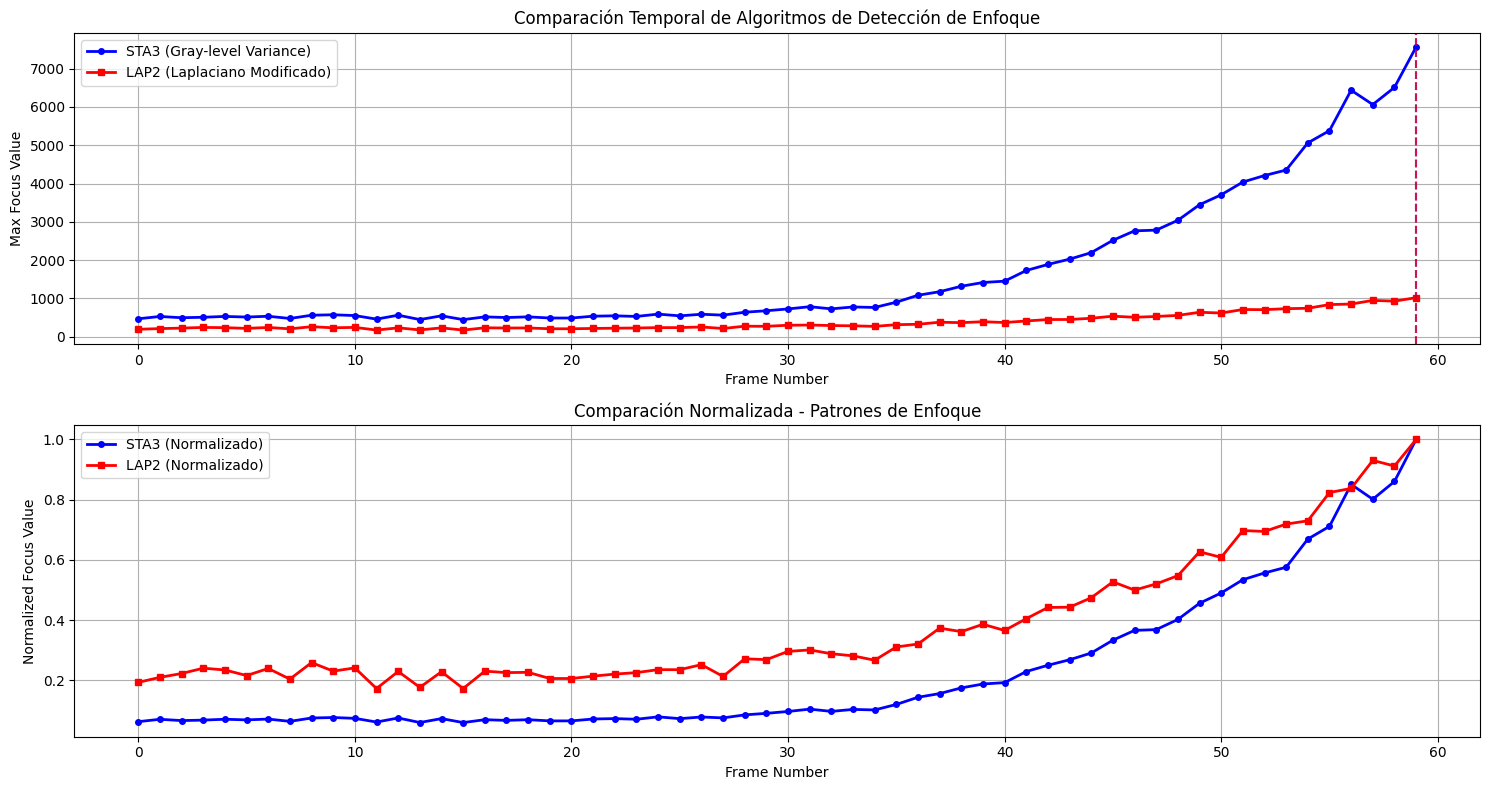


=== ANÁLISIS COMPARATIVO ===
STA3 (Gray-level Variance):
  - Valor máximo: 7563.3335 en frame 59
  - Valor promedio: 1714.1111
  - Desviación estándar: 1833.6893

LAP2 (Laplaciano Modificado):
  - Valor máximo: 1021.0000 en frame 59
  - Valor promedio: 385.8667
  - Desviación estándar: 222.0032

Correlación entre ambos algoritmos: 0.9891
Alta correlación: Ambos algoritmos detectan patrones similares de enfoque


In [29]:
# Análisis temporal: Comparar ambos algoritmos frame a frame
def analyze_focus_algorithms_over_time(input_path, max_frames=50):
    """
    Analiza ambos algoritmos de enfoque a lo largo del tiempo en el video
    """
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frames = min(max_frames, frame_count)  # Limitar para no tardar mucho
    
    focus_values_sta3 = []
    focus_values_lap2 = []
    frame_numbers = []
    
    print(f"Analizando {max_frames} frames con ambos algoritmos...")
    
    for frame_idx in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calcular mapas de enfoque
        focus_map_sta3 = calculate_sta3_focus_measure(frame, window_size=3)
        focus_map_lap2 = calculate_lap2_focus_measure(frame, window_size=3)
        
        # Obtener valores máximos de enfoque
        _, max_value_sta3 = max_focus_points(focus_map_sta3)
        _, max_value_lap2 = max_focus_points(focus_map_lap2)
        
        focus_values_sta3.append(max_value_sta3)
        focus_values_lap2.append(max_value_lap2)
        frame_numbers.append(frame_idx)
        
        if frame_idx % 10 == 0:
            print(f"Procesado frame {frame_idx}/{max_frames}")
    
    cap.release()
    
    return frame_numbers, focus_values_sta3, focus_values_lap2

# Ejecutar el análisis temporal
frame_numbers, focus_sta3, focus_lap2 = analyze_focus_algorithms_over_time(input_path, max_frames=60)

# Visualizar la comparación temporal
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(frame_numbers, focus_sta3, 'b-o', label='STA3 (Gray-level Variance)', linewidth=2, markersize=4)
plt.plot(frame_numbers, focus_lap2, 'r-s', label='LAP2 (Laplaciano Modificado)', linewidth=2, markersize=4)
plt.xlabel('Frame Number')
plt.ylabel('Max Focus Value')
plt.title('Comparación Temporal de Algoritmos de Detección de Enfoque')
plt.legend()
plt.grid(True)

# Encontrar máximos
max_idx_sta3 = np.argmax(focus_sta3)
max_idx_lap2 = np.argmax(focus_lap2)

plt.axvline(x=frame_numbers[max_idx_sta3], color='blue', linestyle='--', alpha=0.7, 
           label=f'Max STA3: frame {frame_numbers[max_idx_sta3]}')
plt.axvline(x=frame_numbers[max_idx_lap2], color='red', linestyle='--', alpha=0.7, 
           label=f'Max LAP2: frame {frame_numbers[max_idx_lap2]}')

plt.subplot(2, 1, 2)
# Normalizar para comparar patrones
focus_sta3_norm = np.array(focus_sta3) / np.max(focus_sta3)
focus_lap2_norm = np.array(focus_lap2) / np.max(focus_lap2)

plt.plot(frame_numbers, focus_sta3_norm, 'b-o', label='STA3 (Normalizado)', linewidth=2, markersize=4)
plt.plot(frame_numbers, focus_lap2_norm, 'r-s', label='LAP2 (Normalizado)', linewidth=2, markersize=4)
plt.xlabel('Frame Number')
plt.ylabel('Normalized Focus Value')
plt.title('Comparación Normalizada - Patrones de Enfoque')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Estadísticas de comparación
print("\n=== ANÁLISIS COMPARATIVO ===")
print(f"STA3 (Gray-level Variance):")
print(f"  - Valor máximo: {np.max(focus_sta3):.4f} en frame {frame_numbers[max_idx_sta3]}")
print(f"  - Valor promedio: {np.mean(focus_sta3):.4f}")
print(f"  - Desviación estándar: {np.std(focus_sta3):.4f}")

print(f"\nLAP2 (Laplaciano Modificado):")
print(f"  - Valor máximo: {np.max(focus_lap2):.4f} en frame {frame_numbers[max_idx_lap2]}")
print(f"  - Valor promedio: {np.mean(focus_lap2):.4f}")
print(f"  - Desviación estándar: {np.std(focus_lap2):.4f}")

# Correlación entre ambos algoritmos
correlation = np.corrcoef(focus_sta3, focus_lap2)[0, 1]
print(f"\nCorrelación entre ambos algoritmos: {correlation:.4f}")

if correlation > 0.8:
    print("Alta correlación: Ambos algoritmos detectan patrones similares de enfoque")
elif correlation > 0.5:
    print("Correlación moderada: Los algoritmos muestran tendencias similares")
else:
    print("Baja correlación: Los algoritmos detectan diferentes características de enfoque")

In [30]:
## Implementación de Unsharp Masking para expandir zonas de enfoque

def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
    """
    Aplica Unsharp Masking a una imagen para realzar los detalles y bordes.
    
    Parameters:
    - image: imagen de entrada (puede ser color o escala de grises)
    - kernel_size: tamaño del kernel para el filtro gaussiano
    - sigma: desviación estándar para el filtro gaussiano
    - amount: factor de intensidad del realce (1.5 es típico)
    - threshold: umbral mínimo para aplicar el realce
    
    Returns:
    - imagen con unsharp masking aplicado
    """
    # Si es imagen a color, trabajar con cada canal
    if len(image.shape) == 3:
        # Aplicar unsharp masking a cada canal
        result = np.zeros_like(image)
        for i in range(image.shape[2]):
            result[:,:,i] = apply_unsharp_mask_single_channel(image[:,:,i], kernel_size, sigma, amount, threshold)
        return result
    else:
        return apply_unsharp_mask_single_channel(image, kernel_size, sigma, amount, threshold)

def apply_unsharp_mask_single_channel(image, kernel_size, sigma, amount, threshold):
    """
    Aplica Unsharp Masking a un canal individual
    """
    # Convertir a float para evitar problemas de overflow
    image_float = image.astype(np.float32)
    
    # Crear filtro gaussiano
    gaussian = cv2.GaussianBlur(image_float, kernel_size, sigma)
    
    # Crear la máscara unsharp: original - gaussiano
    unsharp_mask = image_float - gaussian
    
    # Aplicar threshold si se especifica
    if threshold > 0:
        unsharp_mask = np.where(np.abs(unsharp_mask) < threshold, 0, unsharp_mask)
    
    # Aplicar la máscara: original + amount * máscara
    sharpened = image_float + (amount * unsharp_mask)
    
    # Limitar valores al rango válido [0, 255]
    sharpened = np.clip(sharpened, 0, 255)
    
    return sharpened.astype(np.uint8)

def calculate_focus_with_unsharp(image, algorithm='sta3', window_size=3, 
                                unsharp_params=None):
    """
    Calcula el enfoque aplicando primero Unsharp Masking
    
    Parameters:
    - image: imagen de entrada
    - algorithm: 'sta3' o 'lap2'
    - window_size: tamaño de ventana para el algoritmo de enfoque
    - unsharp_params: diccionario con parámetros de unsharp masking
    
    Returns:
    - focus_map: mapa de enfoque
    - enhanced_image: imagen con unsharp masking aplicado
    """
    # Parámetros por defecto para unsharp masking
    if unsharp_params is None:
        unsharp_params = {
            'kernel_size': (5, 5),
            'sigma': 1.0,
            'amount': 1.5,
            'threshold': 0
        }
    
    # Aplicar unsharp masking
    enhanced_image = apply_unsharp_mask(image, **unsharp_params)
    
    # Calcular enfoque en la imagen realzada
    if algorithm.lower() == 'sta3':
        focus_map = calculate_sta3_focus_measure(enhanced_image, window_size)
    elif algorithm.lower() == 'lap2':
        focus_map = calculate_lap2_focus_measure(enhanced_image, window_size)
    else:
        raise ValueError("Algorithm must be 'sta3' or 'lap2'")
    
    return focus_map, enhanced_image

# Demostración con diferentes parámetros de Unsharp Masking
def demo_unsharp_parameters(image, frame_idx):
    """
    Demuestra el efecto de diferentes parámetros de Unsharp Masking
    """
    # Diferentes configuraciones de Unsharp Masking
    unsharp_configs = [
        {'name': 'Sin Unsharp', 'params': None, 'apply_unsharp': False},
        {'name': 'Suave', 'params': {'kernel_size': (3, 3), 'sigma': 0.5, 'amount': 1.2, 'threshold': 0}, 'apply_unsharp': True},
        {'name': 'Moderado', 'params': {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}, 'apply_unsharp': True},
        {'name': 'Intenso', 'params': {'kernel_size': (7, 7), 'sigma': 1.5, 'amount': 2.0, 'threshold': 0}, 'apply_unsharp': True}
    ]
    
    plt.figure(figsize=(20, 15))
    
    results = []
    
    for idx, config in enumerate(unsharp_configs):
        # Calcular enfoque con ambos algoritmos
        if config['apply_unsharp']:
            focus_map_sta3, enhanced_image = calculate_focus_with_unsharp(
                image, 'sta3', window_size=3, unsharp_params=config['params']
            )
            focus_map_lap2, _ = calculate_focus_with_unsharp(
                image, 'lap2', window_size=3, unsharp_params=config['params']
            )
        else:
            # Sin unsharp masking
            focus_map_sta3 = calculate_sta3_focus_measure(image, window_size=3)
            focus_map_lap2 = calculate_lap2_focus_measure(image, window_size=3)
            enhanced_image = image
        
        # Obtener puntos de máximo enfoque
        max_points_sta3, max_value_sta3 = max_focus_points(focus_map_sta3)
        max_points_lap2, max_value_lap2 = max_focus_points(focus_map_lap2)
        
        # Guardar resultados para estadísticas
        results.append({
            'name': config['name'],
            'sta3_max': max_value_sta3,
            'sta3_mean': np.mean(focus_map_sta3),
            'sta3_points': len(max_points_sta3),
            'lap2_max': max_value_lap2,
            'lap2_mean': np.mean(focus_map_lap2),
            'lap2_points': len(max_points_lap2)
        })
        
        # Visualización
        # Imagen realzada
        plt.subplot(4, 4, idx * 4 + 1)
        if len(enhanced_image.shape) == 3:
            plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(enhanced_image, cmap='gray')
        plt.title(f'{config["name"]}\nImagen Realzada')
        plt.axis('off')
        
        # Mapa de enfoque STA3
        plt.subplot(4, 4, idx * 4 + 2)
        plt.imshow(focus_map_sta3, cmap='hot', interpolation='nearest')
        plt.title(f'STA3 Focus Map\nMax: {max_value_sta3:.2f}')
        plt.colorbar()
        
        # Mapa de enfoque LAP2
        plt.subplot(4, 4, idx * 4 + 3)
        plt.imshow(focus_map_lap2, cmap='hot', interpolation='nearest')
        plt.title(f'LAP2 Focus Map\nMax: {max_value_lap2:.2f}')
        plt.colorbar()
        
        # Puntos de máximo enfoque superpuestos
        plt.subplot(4, 4, idx * 4 + 4)
        overlay = enhanced_image.copy()
        
        # Dibujar puntos STA3 en azul
        for point in max_points_sta3:
            row, col = point
            cv2.circle(overlay, (col, row), 3, (255, 0, 0), -1)
        
        # Dibujar puntos LAP2 en rojo
        for point in max_points_lap2:
            row, col = point
            cv2.circle(overlay, (col, row), 3, (0, 0, 255), -1)
        
        if len(overlay.shape) == 3:
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(overlay, cmap='gray')
        plt.title(f'Max Focus Points\nSTA3: {len(max_points_sta3)}, LAP2: {len(max_points_lap2)}')
        plt.axis('off')
    
    plt.suptitle(f'Efecto del Unsharp Masking en Detección de Enfoque - Frame {frame_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print("=== ESTADÍSTICAS COMPARATIVAS ===")
    print(f"{'Configuración':<12} {'STA3 Max':<10} {'STA3 Mean':<11} {'STA3 Pts':<9} {'LAP2 Max':<10} {'LAP2 Mean':<11} {'LAP2 Pts':<9}")
    print("-" * 80)
    for result in results:
        print(f"{result['name']:<12} {result['sta3_max']:<10.2f} {result['sta3_mean']:<11.4f} {result['sta3_points']:<9} "
              f"{result['lap2_max']:<10.2f} {result['lap2_mean']:<11.4f} {result['lap2_points']:<9}")
    
    return results

In [ ]:
# Ejecutar demostración de Unsharp Masking en el frame de mejor calidad
print(f"Aplicando Unsharp Masking al frame {best_frame_idx} (mejor calidad detectada)")
unsharp_results = demo_unsharp_parameters(best_frame, best_frame_idx)

Analizando efecto de Unsharp Masking en 40 frames...
Procesado frame 0/40
Procesado frame 10/40
Procesado frame 20/40
Procesado frame 30/40


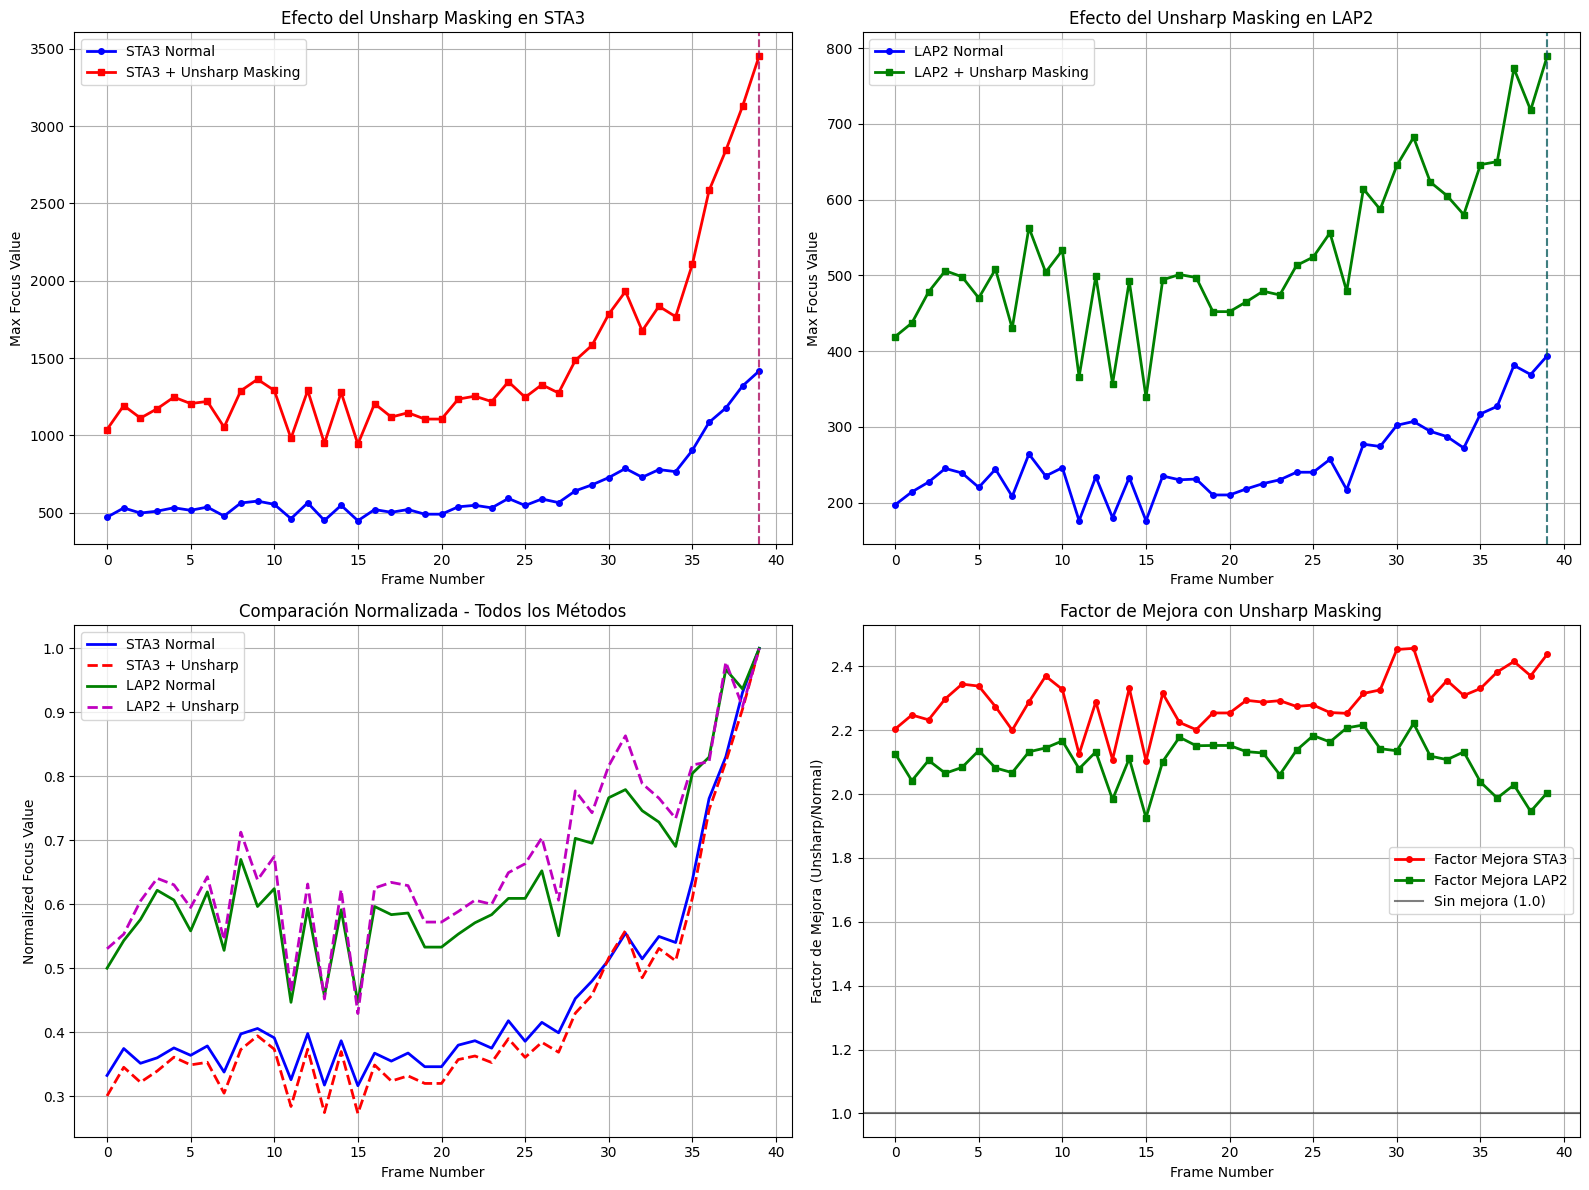


=== ANÁLISIS DE MEJORA CON UNSHARP MASKING ===

STA3 (Gray-level Variance):
  - Factor de mejora promedio: 2.293x
  - Factor de mejora máximo: 2.457x
  - Frames mejorados: 40/40 (100.0%)
  - Valor máximo normal: 1417.1359 en frame 39
  - Valor máximo con unsharp: 3455.8022 en frame 39

LAP2 (Laplaciano Modificado):
  - Factor de mejora promedio: 2.105x
  - Factor de mejora máximo: 2.221x
  - Frames mejorados: 40/40 (100.0%)
  - Valor máximo normal: 394.0000 en frame 39
  - Valor máximo con unsharp: 790.0000 en frame 39

=== CONCLUSIONES ===
✓ Unsharp Masking mejora significativamente STA3
✓ Unsharp Masking mejora significativamente LAP2

El Unsharp Masking es más efectivo para STA3


In [31]:
# Análisis temporal: Comparar algoritmos con y sin Unsharp Masking
def analyze_unsharp_effect_over_time(input_path, max_frames=50):
    """
    Analiza el efecto del Unsharp Masking en la detección de enfoque a lo largo del tiempo
    """
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frames = min(max_frames, frame_count)
    
    # Configuración de Unsharp Masking moderada
    unsharp_params = {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}
    
    # Arrays para almacenar resultados
    frame_numbers = []
    # Sin Unsharp Masking
    focus_sta3_normal = []
    focus_lap2_normal = []
    # Con Unsharp Masking
    focus_sta3_unsharp = []
    focus_lap2_unsharp = []
    
    print(f"Analizando efecto de Unsharp Masking en {max_frames} frames...")
    
    for frame_idx in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Análisis sin Unsharp Masking
        focus_map_sta3_normal = calculate_sta3_focus_measure(frame, window_size=3)
        focus_map_lap2_normal = calculate_lap2_focus_measure(frame, window_size=3)
        
        # Análisis con Unsharp Masking
        focus_map_sta3_enhanced, _ = calculate_focus_with_unsharp(frame, 'sta3', 3, unsharp_params)
        focus_map_lap2_enhanced, _ = calculate_focus_with_unsharp(frame, 'lap2', 3, unsharp_params)
        
        # Obtener valores máximos
        _, max_sta3_normal = max_focus_points(focus_map_sta3_normal)
        _, max_lap2_normal = max_focus_points(focus_map_lap2_normal)
        _, max_sta3_unsharp = max_focus_points(focus_map_sta3_enhanced)
        _, max_lap2_unsharp = max_focus_points(focus_map_lap2_enhanced)
        
        # Almacenar resultados
        frame_numbers.append(frame_idx)
        focus_sta3_normal.append(max_sta3_normal)
        focus_lap2_normal.append(max_lap2_normal)
        focus_sta3_unsharp.append(max_sta3_unsharp)
        focus_lap2_unsharp.append(max_lap2_unsharp)
        
        if frame_idx % 10 == 0:
            print(f"Procesado frame {frame_idx}/{max_frames}")
    
    cap.release()
    return frame_numbers, focus_sta3_normal, focus_lap2_normal, focus_sta3_unsharp, focus_lap2_unsharp

# Ejecutar análisis temporal
frame_nums, sta3_normal, lap2_normal, sta3_unsharp, lap2_unsharp = analyze_unsharp_effect_over_time(input_path, max_frames=40)

# Visualización comparativa
plt.figure(figsize=(16, 12))

# Gráfico 1: STA3 con y sin Unsharp Masking
plt.subplot(2, 2, 1)
plt.plot(frame_nums, sta3_normal, 'b-o', label='STA3 Normal', linewidth=2, markersize=4)
plt.plot(frame_nums, sta3_unsharp, 'r-s', label='STA3 + Unsharp Masking', linewidth=2, markersize=4)
plt.xlabel('Frame Number')
plt.ylabel('Max Focus Value')
plt.title('Efecto del Unsharp Masking en STA3')
plt.legend()
plt.grid(True)

# Encontrar mejoras
max_idx_sta3_normal = np.argmax(sta3_normal)
max_idx_sta3_unsharp = np.argmax(sta3_unsharp)
plt.axvline(x=frame_nums[max_idx_sta3_normal], color='blue', linestyle='--', alpha=0.5)
plt.axvline(x=frame_nums[max_idx_sta3_unsharp], color='red', linestyle='--', alpha=0.5)

# Gráfico 2: LAP2 con y sin Unsharp Masking
plt.subplot(2, 2, 2)
plt.plot(frame_nums, lap2_normal, 'b-o', label='LAP2 Normal', linewidth=2, markersize=4)
plt.plot(frame_nums, lap2_unsharp, 'g-s', label='LAP2 + Unsharp Masking', linewidth=2, markersize=4)
plt.xlabel('Frame Number')
plt.ylabel('Max Focus Value')
plt.title('Efecto del Unsharp Masking en LAP2')
plt.legend()
plt.grid(True)

max_idx_lap2_normal = np.argmax(lap2_normal)
max_idx_lap2_unsharp = np.argmax(lap2_unsharp)
plt.axvline(x=frame_nums[max_idx_lap2_normal], color='blue', linestyle='--', alpha=0.5)
plt.axvline(x=frame_nums[max_idx_lap2_unsharp], color='green', linestyle='--', alpha=0.5)

# Gráfico 3: Comparación normalizada
plt.subplot(2, 2, 3)
sta3_normal_norm = np.array(sta3_normal) / np.max(sta3_normal)
sta3_unsharp_norm = np.array(sta3_unsharp) / np.max(sta3_unsharp)
lap2_normal_norm = np.array(lap2_normal) / np.max(lap2_normal)
lap2_unsharp_norm = np.array(lap2_unsharp) / np.max(lap2_unsharp)

plt.plot(frame_nums, sta3_normal_norm, 'b-', label='STA3 Normal', linewidth=2)
plt.plot(frame_nums, sta3_unsharp_norm, 'r--', label='STA3 + Unsharp', linewidth=2)
plt.plot(frame_nums, lap2_normal_norm, 'g-', label='LAP2 Normal', linewidth=2)
plt.plot(frame_nums, lap2_unsharp_norm, 'm--', label='LAP2 + Unsharp', linewidth=2)
plt.xlabel('Frame Number')
plt.ylabel('Normalized Focus Value')
plt.title('Comparación Normalizada - Todos los Métodos')
plt.legend()
plt.grid(True)

# Gráfico 4: Factor de mejora
plt.subplot(2, 2, 4)
improvement_sta3 = np.array(sta3_unsharp) / np.array(sta3_normal)
improvement_lap2 = np.array(lap2_unsharp) / np.array(lap2_normal)

plt.plot(frame_nums, improvement_sta3, 'r-o', label='Factor Mejora STA3', linewidth=2, markersize=4)
plt.plot(frame_nums, improvement_lap2, 'g-s', label='Factor Mejora LAP2', linewidth=2, markersize=4)
plt.axhline(y=1.0, color='k', linestyle='-', alpha=0.5, label='Sin mejora (1.0)')
plt.xlabel('Frame Number')
plt.ylabel('Factor de Mejora (Unsharp/Normal)')
plt.title('Factor de Mejora con Unsharp Masking')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Estadísticas de mejora
print("\n=== ANÁLISIS DE MEJORA CON UNSHARP MASKING ===")

# STA3 Statistics
sta3_improvement_avg = np.mean(improvement_sta3)
sta3_improvement_max = np.max(improvement_sta3)
sta3_improved_frames = np.sum(improvement_sta3 > 1.0)

print(f"\nSTA3 (Gray-level Variance):")
print(f"  - Factor de mejora promedio: {sta3_improvement_avg:.3f}x")
print(f"  - Factor de mejora máximo: {sta3_improvement_max:.3f}x")
print(f"  - Frames mejorados: {sta3_improved_frames}/{len(frame_nums)} ({100*sta3_improved_frames/len(frame_nums):.1f}%)")
print(f"  - Valor máximo normal: {np.max(sta3_normal):.4f} en frame {frame_nums[max_idx_sta3_normal]}")
print(f"  - Valor máximo con unsharp: {np.max(sta3_unsharp):.4f} en frame {frame_nums[max_idx_sta3_unsharp]}")

# LAP2 Statistics
lap2_improvement_avg = np.mean(improvement_lap2)
lap2_improvement_max = np.max(improvement_lap2)
lap2_improved_frames = np.sum(improvement_lap2 > 1.0)

print(f"\nLAP2 (Laplaciano Modificado):")
print(f"  - Factor de mejora promedio: {lap2_improvement_avg:.3f}x")
print(f"  - Factor de mejora máximo: {lap2_improvement_max:.3f}x")
print(f"  - Frames mejorados: {lap2_improved_frames}/{len(frame_nums)} ({100*lap2_improved_frames/len(frame_nums):.1f}%)")
print(f"  - Valor máximo normal: {np.max(lap2_normal):.4f} en frame {frame_nums[max_idx_lap2_normal]}")
print(f"  - Valor máximo con unsharp: {np.max(lap2_unsharp):.4f} en frame {frame_nums[max_idx_lap2_unsharp]}")

# Conclusiones
print(f"\n=== CONCLUSIONES ===")
if sta3_improvement_avg > 1.1:
    print("✓ Unsharp Masking mejora significativamente STA3")
elif sta3_improvement_avg > 1.05:
    print("• Unsharp Masking mejora moderadamente STA3")
else:
    print("× Unsharp Masking tiene poco efecto en STA3")

if lap2_improvement_avg > 1.1:
    print("✓ Unsharp Masking mejora significativamente LAP2")
elif lap2_improvement_avg > 1.05:
    print("• Unsharp Masking mejora moderadamente LAP2")
else:
    print("× Unsharp Masking tiene poco efecto en LAP2")

print(f"\nEl Unsharp Masking es más efectivo para {'STA3' if sta3_improvement_avg > lap2_improvement_avg else 'LAP2'}")

In [32]:
# Generar video con Unsharp Masking aplicado para mejor visualización
def create_focus_points_video_with_unsharp(input_path, output_path, algorithm='sta3', 
                                          window_size=3, unsharp_params=None, max_frames=None):
    """
    Genera un video que muestra los puntos de máximo enfoque con Unsharp Masking aplicado
    """
    if unsharp_params is None:
        unsharp_params = {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}
    
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames:
        frame_count = min(max_frames, frame_count)
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    algorithm_name = "STA3 + Unsharp" if algorithm.lower() == 'sta3' else "LAP2 + Unsharp"
    
    print(f"Generando video con {algorithm_name} en {frame_count} frames...")
    
    for frame_idx in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Aplicar unsharp masking y calcular enfoque
        focus_map, enhanced_image = calculate_focus_with_unsharp(
            frame, algorithm, window_size, unsharp_params
        )
        max_points, max_value = max_focus_points(focus_map)
        
        # Usar la imagen realzada para el video
        output_frame = enhanced_image.copy()
        
        # Dibujar los puntos de máximo enfoque
        for point in max_points:
            row, col = point
            cv2.circle(output_frame, (col, row), 5, (0, 255, 255), -1)  # Amarillo para distinguir
            cv2.circle(output_frame, (col, row), 15, (0, 255, 255), 2)
        
        # Texto informativo
        text1 = f'Frame: {frame_idx} | {algorithm_name}'
        text2 = f'Max Focus: {max_value:.2f} | Points: {len(max_points)}'
        text3 = f'Unsharp: σ={unsharp_params["sigma"]}, Amount={unsharp_params["amount"]}'
        
        cv2.putText(output_frame, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        cv2.putText(output_frame, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        cv2.putText(output_frame, text3, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(output_frame, text3, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        out.write(output_frame)
        
        if frame_idx % 10 == 0:
            print(f"Procesado frame {frame_idx}/{frame_count}")
    
    cap.release()
    out.release()
    
    print(f"Video con Unsharp Masking guardado en: {output_path}")
    return output_path

# Generar videos de demostración con Unsharp Masking
input_video = "data/focus_video.mov"

# Configuraciones de Unsharp Masking para demostrar
unsharp_moderate = {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}
unsharp_intense = {'kernel_size': (7, 7), 'sigma': 1.5, 'amount': 2.0, 'threshold': 0}

print("Generando videos con Unsharp Masking...")

# Video STA3 + Unsharp Masking moderado
output_sta3_unsharp = "outputs/focus_points_STA3_Unsharp_Moderate.mp4"
create_focus_points_video_with_unsharp(
    input_video, output_sta3_unsharp, 'sta3', 3, unsharp_moderate, max_frames=60
)

# Video LAP2 + Unsharp Masking intenso  
output_lap2_unsharp = "outputs/focus_points_LAP2_Unsharp_Intense.mp4"
create_focus_points_video_with_unsharp(
    input_video, output_lap2_unsharp, 'lap2', 3, unsharp_intense, max_frames=60
)

print("\n=== VIDEOS GENERADOS ===")
print(f"1. STA3 + Unsharp Moderado: {output_sta3_unsharp}")
print(f"2. LAP2 + Unsharp Intenso: {output_lap2_unsharp}")
print("\nCompara estos videos con los originales para ver el efecto del Unsharp Masking")

Generando videos con Unsharp Masking...
Generando video con STA3 + Unsharp en 60 frames...
Procesado frame 0/60
Procesado frame 10/60
Procesado frame 20/60
Procesado frame 30/60
Procesado frame 40/60
Procesado frame 50/60
Video con Unsharp Masking guardado en: outputs/focus_points_STA3_Unsharp_Moderate.mp4
Generando video con LAP2 + Unsharp en 60 frames...
Procesado frame 0/60
Procesado frame 10/60
Procesado frame 20/60
Procesado frame 30/60
Procesado frame 40/60
Procesado frame 50/60
Video con Unsharp Masking guardado en: outputs/focus_points_LAP2_Unsharp_Intense.mp4

=== VIDEOS GENERADOS ===
1. STA3 + Unsharp Moderado: outputs/focus_points_STA3_Unsharp_Moderate.mp4
2. LAP2 + Unsharp Intenso: outputs/focus_points_LAP2_Unsharp_Intense.mp4

Compara estos videos con los originales para ver el efecto del Unsharp Masking
